In [12]:
import random

import matplotlib.pyplot as plt
import seaborn as sns

Markov chain Monte Carlo is a computational method that uses samples to understand complex distributions. It takes these samples by simulating a cleverly constructed Markov chain for a long time. This method has proven useful in many problems in areas such as fraud detection, modelling genetic networks and deciphering codes. 

In this post, I use Markov chain Monte Carlo simulations to answer an interesting question regarding the knight, a powerful chess piece whose movement is much unlike any other:

> Suppose a knight is moving randomly about a chessboard. If you were to observe the position of the knight at some random time way out in the future, what is the probability that the knight is on any specified square?

Here, moving randomly means that, at each step, the knight's next move is chosen uniformly from all legal moves. For example, if the knight is on a corner square then it has 2 possible legal moves, each with probability $\frac{1}{2}$ of occurring. 

## A Bit About Markov Chains

A stochastic process is a mathematical system that transitions from one state to another according to certain probabilistic rules. A Markov chain a specific class of stochastic process with the restriction that the probability of transitioning to any particular state depends only on the current state. This is called the **Markov property**. 

> **The Markov Property**
>
> For any positive integer $n$ and possible states $i_0, i_1, \dots , i_n$ of the random variables,
>
> $$ \mathbb{P}(X_n = i_n |X_0 = i_0, X_1 = i_1, \dots, X_{n-1} = i_{n-1}) =  \mathbb{P}(X_n = i_n |X_{n-1} = i_{n-1})$$

An example of a Markov chain is a board game such as snakes and ladders. After rolling the die, your next position depends only on your current position—how you reached this current position does not influence your next position.

The **state space** for this problem, which is the set of all possible states, corresponds to the set of all squares on a chessboard. So, as the knight moves randomly from square to square, the system will transition from state to state.

There are multiple ways we could define the state space, but the most intuitive is as pairs of integers representing the row and column number. In other words, our statespace is $S = \{1, 2, \dots, 8\}^2$, with each state representing a unique square.

We then obtain our transition probablities by looking at how many legal moves we can take from each state.

$$\mathbb{P}(X_{n+1} = j | X_n = i) = \begin{cases} 
      \frac{1}{\#\{\text{legal moves}\}} & i \rightarrow j \text{ legal} \\
      0 & \text{otherwise}
   \end{cases} \qquad i, j \in S
$$

### Properties of Markov Chains

It will be useful to understand the following properties relating to Markov chains:

* The **period** $k$ of a state $i$ is the largest number such that the chain can only return to state $i$ in multiples of $k$. In other words, if a state has period $k$, it is impossible to return to a number of steps that is not a multiple of $k$, yet it can be guaranteed that _eventually_ you can return in a multiple of $k$ steps.
* If $k = 1$ then the state is called **aperiodic**, and if $k>1$ the state is called **periodic** with period $k$.
* If all states are aperiodic, then the Markov chain is called _aperiodic_.
* A Markov chain is known as **irreducible** if there exists a chain of steps between any two states that has positive probability.
* Finally, a Markov chain is positive recurrent if we expect any chain to return to its starting point in finite time.

Our chess-based Markov change is indeed irreducible, since no matter which square the knight is currently on, it can eventually travel to any other square (it is up to you to think why this is the case). It is also positive recurrent, although this is harder to prove.

It is also useful to note, that if the knight is currently on a black square, and then takes an odd number of moves, it is guaranteed to end up on a white square. And so, in particular, for the knight to return to any square visited, it must take an even number of moves from when it was last on the square. In addition, a return to any square can be made in just 2 moves simply by jumping to any other square and then back. All states in the knight's Markov chain therefore have period 2. This means the chain is not aperiodic, which will cause us some minor inconvenience later.

### Stationary Distributions

The probability distribution of a Markov chain will generally change as time progresses. For "nice" Markov chains that have certain properties, however, the probability distribution will eventually converge to a unique distribution and remain stable. This distribution is called the stationary distribution $\pi = (\pi_1, \pi_2,  \dots, \pi_{n})$.

We can interpret $\pi$ as the probability distribution for the state of the Markov chain if we stopped it at some random time way out in the future. In our case, $\pi_j$ corresponds to the probability that the knight is on the square represented by state $j$ once the distribution of its position has stabalised. 

In other words, if we can find the stationary distribution of the knight taking random legal moves on a chessboard, we will have answered our question! We just need a way to calculate this stationary distribution.

To do this, we can observe that for any $i\in S$

$$ \pi_j = \lim_{n \to \infty} \frac{1}{n}\sum_{m=1}^n \mathbb{1}\{X_m = j |X_0 = i\}$$

where $\mathbb{1}$ is the indicator function. A proof of this fact can be found in section 2.3 [here](http://www.columbia.edu/~ks20/stochastic-I/stochastic-I-MCII.pdf).

## Simulating a Solution

With equation (1) in mind, we can use simulation to compute the stationary distribution of interest and solve our problem. The code for doing this is as follows.

In [28]:
moves = [(-2, 1), (-1, 2), (1, 2), (2, 1),
         (2, -1), (1, -2), (-1, -2), (-2, -1)]

def get_legal_moves(position):
    """For an inputted position, return a list of possible moves"""
    legal_moves = []
    for move in moves:
        new_pos = (position[0] + move[0], position[1] + move[1])
        if 0 <= new_pos[0] <= 7 and 0 <= new_pos[1] <= 7:
            legal_moves.append(move)
    return legal_moves


def simulate(start_pos, num_moves):
    """
    Given a starting position, simulate doing n moves.

    Records the number of times each state was visited.
    """

    cur_pos = start_pos
    counts = [[0 for j in range(8)] for i in range(8)]

    for __ in range(num_moves):
        legal_moves = get_legal_moves(cur_pos)
        chosen_move = random.choice(legal_moves)
        cur_pos = (cur_pos[0] + chosen_move[0], cur_pos[1] + chosen_move[1])
        counts[cur_pos[0]][cur_pos[1]] += 1

    return normalise_counts(counts)

def normalise_counts(counts):
    total = sum(sum(row) for row in counts)
    return [[c / total for c in row] for row in counts]

pi = simulate((0, 0), 100000)

We can then visualise the simulated distributions.

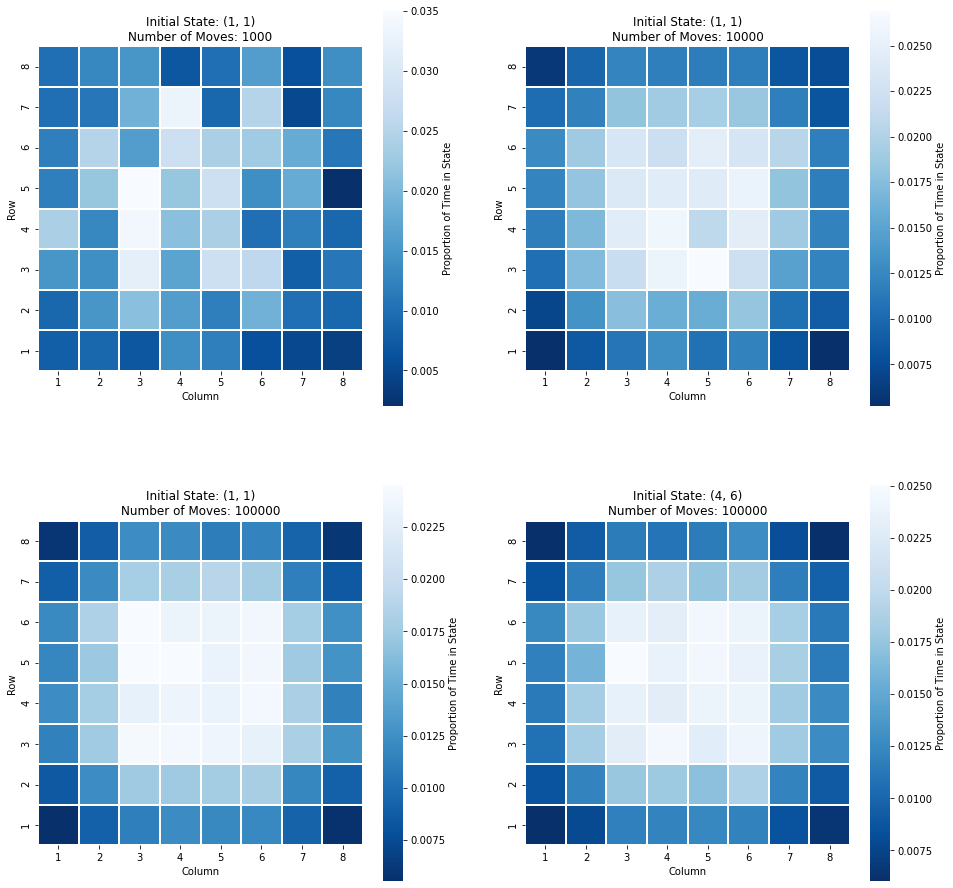

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(16, 16))
start_pos = [(0, 0), (0, 0), (0, 0), (3, 5)]
num_moves = [1000, 10000, 100000, 100000]
for i, (s, n) in enumerate(zip(start_pos, num_moves)):
    ax = axs[i // 2][i % 2]
    sims = simulate(s, n)
    sns.heatmap(sims, cmap = "Blues_r", linewidths = 1, ax = ax,
                cbar_kws={"label" : "Proportion of Time in State"}, 
                yticklabels = "87654321", xticklabels = "12345678")
    ax.set_aspect('equal')
    ax.set_xlabel("Column")
    ax.set_ylabel("Row")
    ax.set_title(f"Initial State: ({s[0]+1}, {s[1]+1})\nNumber of Moves: {n}")

These visualisations illustrate how, as the number of simulated moves increases, the approximation of the stationary distribution converges.

The penultimate image—obtained from a simulation of the knight taking one million moves—is almost equal to the true stationary distribution. It shows that, if you were to observe the position of a knight taking random legal moves on a chessboard at some random time way out in the future, the knight is most likely to be on one of the 16 central squares and very unlikely to be on one of the four corner squares. This intuitively makes sense, as each square in the central light blue area can be reached by a knight in 8 different positions, whereas each corner square can only be reached by 2 positions. 

The stationary distribution is naturally independent of the starting position of the knight. In the final visualisation we again see a knight taking one million moves, but starting from state $(4, 6)$.

## The Transition Matrix

Although the Monte Carlo approach above provides a general and conceptual-simple framework for calculating a Markov chain's stationary distribution, move efficient approaches do exist. For example, using the transition matrix.

Every Markov Chain has a corresponding matrix which describes the probabilities of transitioning between states. This is called the **transition matrix** of the Markov chain. In the special case of time-homogenous Markov chains (which it so happens we are looking at), this matrix does not change with time.

In this case, given an ordering of the matrix's rows and columns by the state space, the $(i, j)$th entry of the transition matrix $P$ gives the probability of moving to state $j$ from state $i$.

$$ P_{(i,j)} = \mathbb{P}(X_{n+1} = j |X_n = i)$$

For the Markov chain representing a knight moving randomly on a chessboard, the corresponding transition matrix will be a $64 \times 64$ matrix. We will then flatten out our $8\times 8$ state space into a 64-dimensional vector by running through each row sequentially.

Transition matrices have the useful property that the $(i, j)$th entry of the matrix $P^n$ gives the probability that the Markov chain, starting in state $i$, will be in state $j$ after $n$ steps.

$$ (P^n)_{(i,j)} = P(X_n = j|X_0 = i) $$

Therefore, for any time-homogeneous Markov chain that is aperiodic and irreducible, 

$$ \lim_{n \to \infty}P^n $$

converges to a matrix with all rows the same and equal to the stationary distribution of the Markov chain.

As the Markov chain for the knight is periodic with period 2, the above equation does not hold. Instead,  

$$ \frac{1}{2} \lim_{n \to \infty}\left(P^n + P^{n+1}\right) = \frac{1}{2} \lim_{n \to \infty}P^n\left(I_{64} + P\right) \tag{2}$$

will converge to a matrix with all rows the same and equal to the stationary distribution. Here, $I_{64}$ is the $64 \times 64$ identity matrix and is included to make our calculations more efficient. 

To verify the accuracy of the stationary distribution found by simulations, we can use the following code to generate the required transition matrix. Using  equation (2) given above, we can then recalculate the stationary distribution for comparison.

In [81]:
valid_move = np.empty((64, 64), dtype=np.float)
for i in range(64):
    i_row, i_col = divmod(i, 8)
    for j in range(64):
        j_row, j_col = divmod(j, 8)
        valid_move[i, j] = (i_row - j_row, i_col - j_col) in moves

# Since choices are uniform, we just have to make rows sum to one
row_sums = valid_move.sum(axis=1, keepdims=True)
P = valid_move / row_sums

# Calculating average of P to the n and P to the n + 1, for large n
n = 1000000
lim_P = 1/2 * np.linalg.matrix_power(P, n) @ (np.eye(64) + P)

# Verifying that all rows sum to one
print("Rows approximately sum to one:",
      np.all(np.isclose(lim_P.sum(axis=1), 1)))

Rows approximately sum to one: True


As before, we can visualise the result.




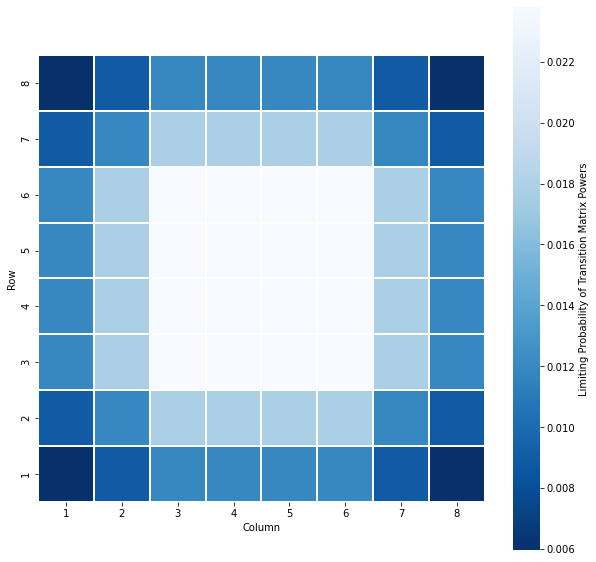

In [110]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(lim_P[0].reshape(8, 8), 
            cmap = "Blues_r", linewidths = 1, ax = ax,
            cbar_kws={"label":
                      "Limiting Probability of Transition Matrix Powers"}, 
            yticklabels = "87654321", xticklabels = "12345678")
ax.set_aspect('equal')
ax.set_xlabel("Column")
ax.set_ylabel("Row")
plt.show()

This is exactly what we would hope to see! The stationary distribution found using the transition matrix matches the stationary distribution found by simulations, verifying the result. 

## Conclusion

The applications of Markov chain Monte-Carlo are wide, varied, and ever-growing. I think the following quote encapsulates this idea nicely.

>"*To someone working in my part of the world, asking about applications of Markov chain Monte Carlo is a little like asking about applications of the quadratic formula. The results are really used in every aspect of scientific inquiry.* "
>
> — Persi Diaconis, Departments of Mathematics and Statistics, Stanford University

I hope you have enjoyed reading, and perhaps gained an insight into how you may use Monte Carlo Markov chain methods in your own work. 